In [29]:
import pandas as pd
import numpy as np
import re
import sklearn

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

import matplotlib.pyplot as plt

In [2]:
def rest(df):
    game = np.array(df['G'].fillna(0))
    rested = game == 0
    df['Rest'] = rested*1
    return df

def str_to_int(s):
    if type(s) == int or type(s) == float:
        return s
    if len(re.findall('\d', s)) != 0:
        if '.' in s:
            return float(s)
        return int(s[:2])
    return 0

def min_to_int(s):
    if len(re.findall('\d', s)) != 0:
        return int(s.split(':')[0])
    return 0

def plus_min(s):
    if type(s) == int or type(s) == float:
        return s
    if len(re.findall('\d', s)) == 0:
        return 0
    if s[0] == '-':
        return int(s[1:]) * -1
    if s[0] == '+':
        return int(s[1:]) 
    return 0

def meaner(df, col):
    col_vals = df[col].apply(str_to_int).values
    length = len(col_vals)
    df[col] = np.cumsum(col_vals)/(np.arange(length) + 1)
    return df

def meaner_min(df, col):
    col_vals = df[col].apply(min_to_int).values
    length = len(col_vals)
    df[col] = np.cumsum(col_vals)/(np.arange(length) + 1)
    return df

def meaner_int(df, col):
    col_vals = df[col].values
    length = len(col_vals)
    df[col] = np.cumsum(col_vals)/(np.arange(length) + 1)
    return df

def games(df, col):
    game = df[col].fillna(0)
    length = len(game)
    new_game = []
    for i in np.arange(length):
        new_game.append(max(game[:(i + 1)]))
    df[col] = new_game
    return df

def manipulate(df, inj, player):
    df = df.drop(labels=['Tm', 'GS', 'Unnamed: 5', 'Opp', 'PF', 'Unnamed: 7'], axis=1)
    df = rest(df) 
    df['Age'] = df['Age'].apply(str_to_int) 
    
    df['+/-'] = df['+/-'].apply(plus_min) 
    
    df = games(df, 'G')
    df = meaner_min(df, 'MP')
    df = meaner(df, 'FG')
    df = meaner(df, 'FGA')
    df = meaner(df, '3P')
    df = meaner(df, '3PA')
    df = meaner(df, 'FT')
    df = meaner(df, 'FTA')
    
    df['FG%'] = df['FG']/df['FGA']
    df['3P%'] = df['3P']/df['3PA']
    df['FT%'] = df['FT']/df['FTA']
    
    df = meaner(df, 'ORB') 
    df = meaner(df, 'DRB')
    df = meaner(df, 'TRB')
    df = meaner(df, 'AST')
    df = meaner(df, 'STL')
    df = meaner(df, 'BLK')
    df = meaner(df, 'TOV')
    df = meaner(df, 'PTS')
    df = meaner(df, 'GmSc')
    
    df = meaner_int(df, '+/-')
    
    player_i = inj[inj['Relinquised'] == player]
    player_i = player_i[['Date', 'score']]
    
    df = df.merge(player_i, how='left')
    df['score'] = df['score'].fillna(0)
    df['score'] = np.cumsum(df['score'].values)
    df = df.drop('Date', axis=1)
    return df

In [3]:
data = pd.read_csv("aabmlogs.csv")
data = data.fillna(0)

In [4]:
np.random.seed(42)
norest = data[data['Rest']==0]
samples = norest.sample(n=10000)

In [5]:
undersample = data.drop(samples.index)
data = undersample
sum(undersample['Rest']), len(undersample)

(6244.0, 27619)

In [6]:
train, val = train_test_split(data, test_size=.2, random_state=0)

In [7]:
train.head()

,G,Age,MP,FG,FGA,FG%,3P,3PA,3P%,FT,...,TRB,AST,STL,BLK,TOV,PTS,GmSc,+/-,score,Rest
24639,14.0,20.0,17.142857,2.285714,4.857143,0.470588,1.071429,2.571429,0.416667,0.785714,...,2.285714,1.142857,0.928571,0.071429,0.428571,6.428571,5.235714,4.642857,0.0,0.0
16725,25.0,23.0,29.500000,4.846154,9.846154,0.492188,1.307692,3.615385,0.361702,0.961538,...,5.115385,0.884615,1.000000,0.615385,1.230769,11.961538,8.976923,-0.538462,0.0,0.0
24901,25.0,25.0,19.566667,2.466667,4.633333,0.532374,0.333333,0.600000,0.555556,0.433333,...,2.900000,4.066667,0.900000,0.166667,1.666667,5.700000,5.990000,-1.166667,1.0,0.0
30571,24.0,22.0,30.807692,6.076923,12.269231,0.495298,2.076923,5.115385,0.406015,3.000000,...,7.653846,2.038462,0.961538,0.846154,1.423077,17.230769,14.403846,-1.923077,0.0,0.0
4157,41.0,29.0,19.261905,2.500000,4.642857,0.538462,0.285714,0.761905,0.375000,0.952381,...,4.500000,1.809524,0.571429,0.690476,0.833333,6.238095,6.254762,1.476190,1.0,0.0


In [8]:
feat = ['G', 'Age', 'MP', 'FGA', '3PA', 'FTA', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', 'GmSc',
       '+/-', 'score']
pca_feat = ['G', 'MP', 'Age', '+/-', 'TRB', 'AST', 'score', '3PA', 'FGA']
X_train, y_train = train[feat], train[['Rest']]
X_val, y_val = val[feat], val[['Rest']]

In [9]:
X_train.columns, y_train.columns

(Index(['G', 'Age', 'MP', 'FGA', '3PA', 'FTA', 'TRB', 'AST', 'STL', 'BLK',
        'TOV', 'PTS', 'GmSc', '+/-', 'score'],
       dtype='object'), Index(['Rest'], dtype='object'))

In [10]:
len(X_train.columns), len(y_train.columns)

(15, 1)

## Decision Tree 

In [11]:
tree = DecisionTreeClassifier()
grid = {'max_depth': range(10, 50, 5),
              'min_samples_split' : range(2, 12, 2),
              'max_features' : range(4, 15, 2)}
cv = GridSearchCV(tree, param_grid=grid, scoring='recall', verbose=1, cv=3)
cv.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  2.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': range(10, 50, 5),
                         'max_features': range(4, 15, 2),
                      

In [12]:
cv.best_score_, cv.best_params_

(0.691681556482033,
 {'max_depth': 35, 'max_features': 14, 'min_samples_split': 2})

In [13]:
tree = DecisionTreeClassifier(max_depth=40, max_features=14, min_samples_split=2)
cross_validate(tree, X=X_train, y=y_train, cv=5, verbose=1, scoring='recall', return_train_score=True)['test_score'].mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished


0.7063761999337967

In [14]:
tree = DecisionTreeClassifier(max_depth=40, max_features=8, min_samples_split=2)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=40,
                       max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [15]:
pred = tree.predict(X_val)
accuracy_score(y_val, pred)

0.8578928312816799

In [16]:
recall_score(y_val, pred), precision_score(y_val, pred), f1_score(y_val, pred)

(0.7009113504556752, 0.6661417322834645, 0.6830843762616067)

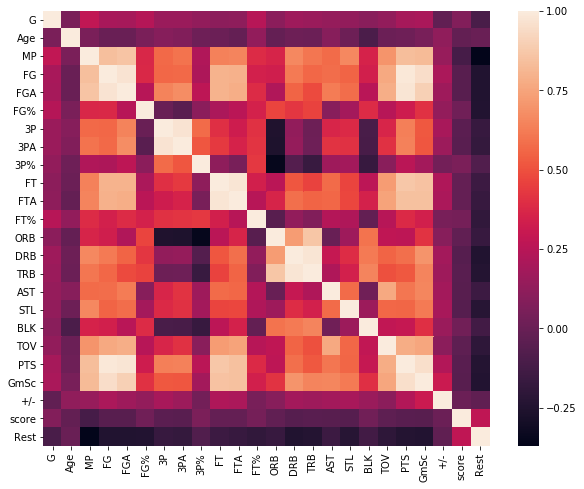

In [17]:
import seaborn as sns
%matplotlib inline

corr = data.corr()

# plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [18]:
test = pd.DataFrame(data.iloc[0, :]).T.iloc[:, :23]
test.score = 0
test['3P'] = 30
test

,G,Age,MP,FG,FGA,FG%,3P,3PA,3P%,FT,...,DRB,TRB,AST,STL,BLK,TOV,PTS,GmSc,+/-,score
0,1.0,21.0,29.0,4.0,9.0,0.444444,30,1.0,1.0,4.0,...,4.0,6.0,3.0,0.0,0.0,3.0,13.0,8.8,-12.0,0


## MLP Classifier

In [19]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)

/srv/app/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [20]:
pred = mlp.predict(X_val)
accuracy_score(y_val, pred)

0.8416002896451846

In [21]:
recall_score(y_val, pred), precision_score(y_val, pred), f1_score(y_val, pred)

(0.34134217067108535, 0.8373983739837398, 0.4849911712772219)

## Logistic Regression 

In [22]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

/srv/app/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/srv/app/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
pred = lr.predict(X_val)
accuracy_score(y_val, pred)

0.8240405503258509

In [24]:
recall_score(y_val, pred), precision_score(y_val, pred), f1_score(y_val, pred)

(0.37033968516984256, 0.6783004552352049, 0.4790996784565917)

## Testing

In [25]:
dray = pd.read_csv('draymond.csv')
leb = pd.read_csv('lebron.csv')
dray

,Rk,G,Date,Age,Tm,Unnamed: 5,Opp,Unnamed: 7,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1,1.0,2019-10-24,29-234,GSW,NaN,LAC,L (-19),1,28:25,...,4,4,3,1,0,0,3,11,11.1,-35
1,2,2.0,2019-10-27,29-237,GSW,@,OKC,L (-28),1,23:57,...,5,5,2,2,0,1,2,10,8.4,-23
2,3,3.0,2019-10-28,29-238,GSW,@,NOP,W (+11),1,33:53,...,14,17,10,2,0,4,1,16,20.9,+36
3,4,4.0,2019-10-30,29-240,GSW,NaN,PHO,L (-11),1,23:45,...,5,5,4,1,0,1,2,4,1.9,-30
4,5,5.0,2019-11-01,29-242,GSW,NaN,SAS,L (-17),1,34:26,...,7,8,7,1,0,1,3,6,8.4,-16
5,6,NaN,2019-11-02,29-243,GSW,NaN,CHO,L (-6),Did Not Dress,Did Not Dress,...,Did Not Dress,Did Not Dress,Did Not Dress,Did Not Dress,Did Not Dress,Did Not Dress,Did Not Dress,Did Not Dress,Did Not Dress,Did Not Dress
6,7,NaN,2019-11-04,29-245,GSW,NaN,POR,W (+9),Did Not Play,Did Not Play,...,Did Not Play,Did Not Play,Did Not Play,Did Not Play,Did Not Play,Did Not Play,Did Not Play,Did Not Play,Did Not Play,Did Not Play
7,8,NaN,2019-11-06,29-247,GSW,@,HOU,L (-17),Inactive,Inactive,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive
8,9,NaN,2019-11-08,29-249,GSW,@,MIN,L (-6),Inactive,Inactive,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive
9,10,NaN,2019-11-09,29-250,GSW,@,OKC,L (-6),Inactive,Inactive,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive


In [31]:
injuries_d = {
    'Relinquised': ['Draymond Green', 'Draymond Green', 'Draymond Green', 'Draymond Green', 'Draymond Green', 
                    'Draymond Green', 'Draymond Green', 'Draymond Green'],
    'Date' : ['2019-11-02', '2019-11-04', '2019-11-06', '2019-11-08', '2019-11-09', 
              '2019-11-20', '2019-11-22', '2019-11-25'],
    'score' : [7, 0, 0, 0, 0, 1, 1, 1]
} 
injured_19 = pd.DataFrame(data=injuries_d)
injured_19

,Relinquised,Date,score
0,Draymond Green,2019-11-02,7
1,Draymond Green,2019-11-04,0
2,Draymond Green,2019-11-06,0
3,Draymond Green,2019-11-08,0
4,Draymond Green,2019-11-09,0
5,Draymond Green,2019-11-20,1
6,Draymond Green,2019-11-22,1
7,Draymond Green,2019-11-25,1


In [33]:
new_dray = manipulate(dray, injured_19, 'Draymond Green')
new_dray.drop('Rk', axis=1, inplace=True)

In [53]:
dd = new_dray.loc[20:21].drop('Rest', axis=1)
dd[feat]

,G,Age,MP,FGA,3PA,FTA,TRB,AST,STL,BLK,TOV,PTS,GmSc,+/-,score
20,13.0,29,16.952381,4.809524,1.619048,1.190476,4.047619,3.47619,0.809524,0.333333,1.238095,5.285714,5.52381,-4.809524,10.0


In [55]:
dl = new_leb.loc[19:20]#.drop('Rest', axis=1)
dl[feat]

,G,Age,MP,FGA,3PA,FTA,TRB,AST,STL,BLK,TOV,PTS,GmSc,+/-,score
19,20,34,34.5,19.75,5.8,5.65,7.15,10.85,1.45,0.6,3.8,25.65,22.635,8.4,0.0


In [44]:
predd = tree.predict(dd[feat])

In [45]:
predd

array([1., 1.])

In [47]:
new_leb = manipulate(leb, injured_19, 'LeBron James')
new_leb.drop('Rk', axis=1, inplace=True)
new_leb

,G,Age,MP,FG,FGA,FG%,3P,3PA,3P%,FT,...,TRB,AST,STL,BLK,TOV,PTS,GmSc,+/-,Rest,score
0,1,34,36.000000,7.000000,19.000000,0.368421,1.000000,5.000000,0.200000,3.000000,...,10.000000,8.000000,1.000000,1.000000,5.000000,18.000000,11.600000,-8.000000,0,0.0
1,2,34,33.000000,9.500000,20.500000,0.463415,1.000000,4.500000,0.222222,5.000000,...,8.500000,9.000000,1.000000,0.500000,3.000000,25.000000,21.250000,4.500000,0,0.0
2,3,34,33.666667,8.666667,18.333333,0.472727,1.000000,4.000000,0.250000,5.000000,...,7.666667,10.000000,1.000000,0.333333,3.333333,23.333333,21.033333,8.666667,0,0.0
3,4,34,32.250000,8.500000,17.500000,0.485714,1.250000,4.250000,0.294118,5.000000,...,6.250000,9.500000,0.750000,0.500000,4.000000,23.250000,19.725000,7.000000,0,0.0
4,5,34,34.200000,9.400000,18.600000,0.505376,1.800000,5.200000,0.346154,5.800000,...,7.400000,10.800000,1.400000,0.600000,4.000000,26.400000,23.940000,8.600000,0,0.0
5,6,34,34.666667,9.166667,19.333333,0.474138,1.500000,5.333333,0.281250,5.666667,...,8.000000,11.166667,1.500000,0.666667,4.166667,25.500000,22.583333,9.666667,0,0.0
6,7,34,34.714286,9.285714,19.285714,0.481481,1.571429,5.428571,0.289474,6.000000,...,8.285714,11.142857,1.571429,0.714286,3.857143,26.142857,23.714286,10.714286,0,0.0
7,8,34,34.875000,9.375000,19.250000,0.487013,1.875000,5.625000,0.333333,5.375000,...,7.750000,10.500000,1.375000,0.625000,3.750000,26.000000,22.912500,11.375000,0,0.0
8,9,34,34.888889,8.888889,18.777778,0.473373,1.666667,5.222222,0.319149,5.111111,...,8.333333,11.000000,1.222222,0.666667,3.555556,24.555556,22.322222,9.444444,0,0.0
9,10,34,35.100000,8.800000,18.700000,0.470588,1.600000,5.100000,0.313725,4.800000,...,8.200000,11.000000,1.100000,0.600000,3.300000,24.000000,21.730000,8.300000,0,0.0


In [50]:
lb = new_leb.loc[19:21].drop('Rest', axis=1)
lb

,G,Age,MP,FG,FGA,FG%,3P,3PA,3P%,FT,...,DRB,TRB,AST,STL,BLK,TOV,PTS,GmSc,+/-,score
19,20,34,34.5,9.9,19.75,0.501266,2.0,5.8,0.344828,3.85,...,6.2,7.15,10.85,1.45,0.6,3.8,25.65,22.635,8.4,0.0


In [51]:
predl = tree.predict(lb[feat])
predl

array([0.])